# Dataset Description Newsela
This notebook describes the Newsela dataset. Activate the environment by `conda activate data-description`

In [1]:
import math
import textstat
import locale
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import path, getcwd
from nltk import sent_tokenize, word_tokenize
from util import map_nltk_lang
from datasets import load_dataset, Features, Value
from easse.fkgl import corpus_fkgl
from statistics import mean

In [2]:
# Config
sns.set_theme(style="white", context="talk")
sns.set_context('notebook')
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

# Load data

In [3]:
features = Features({"complex_sent": Value("string"), "simple_sent": Value("string")})
ds = load_dataset("../src/data/newsela", features=features)
ds = ds.rename_columns({"complex_sent": "src", 'simple_sent': "tgt"})

Found cached dataset csv (/home/julez/.cache/huggingface/datasets/csv/newsela-c7e38817ed2ee841/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
df_train = ds["train"].to_pandas()
df_test = ds["test"].to_pandas()
df_valid = ds["validation"].to_pandas()

In [5]:
df_train.head()

,src,tgt
0,It found that eight of the 60 countries with p...,It found that eight of the 60 countries with p...
1,"The 6.3 million figure is around 200,000 fewer...",The 6.3 million deaths in 2013 compares with 6...
2,How do poor countries take the steps needed to...,How do poor countries take the steps needed to...
3,"In Peru, more women are giving birth in hospit...","In Peru, more women are giving birth in hospit..."
4,"""It is not enough to know where a clinic is.","It's not enough to know where a hospital is, n..."


# Number of Instances

In [6]:
df = pd.concat([df_train, df_test, df_valid], ignore_index=True)

In [20]:
df

,src,tgt
0,It found that eight of the 60 countries with p...,It found that eight of the 60 countries with p...
1,"The 6.3 million figure is around 200,000 fewer...",The 6.3 million deaths in 2013 compares with 6...
2,How do poor countries take the steps needed to...,How do poor countries take the steps needed to...
3,"In Peru, more women are giving birth in hospit...","In Peru, more women are giving birth in hospit..."
4,"""It is not enough to know where a clinic is.","It's not enough to know where a hospital is, n..."
...,...,...
299226,"Only Taylor Swift's ""1989"" and the ""Frozen"" so...","Only Taylor Swift's ""1989"" and the ""Frozen"" so..."
299227,"Katy Perry's ""Prism"" album also did very well ...","Katy Perry's album ""Prism"" also did very well ..."
299228,He said they showed respect for him and his mu...,He said he liked how Capitol respected him and...
299229,Smith said it was a done deal when he met with...,"It was a done deal when he met Barnett, he said."


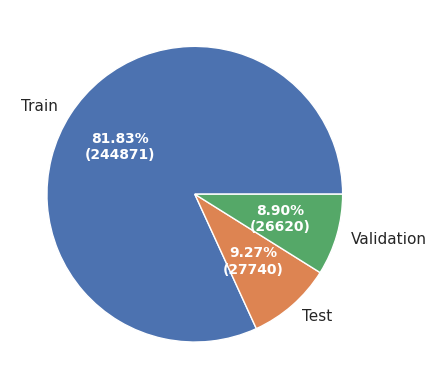

In [22]:
labels = ["Train", "Test", "Validation"]
sizes = [len(df_train.index), len(df_test.index), len(df_valid.index)]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct


fig, ax = plt.subplots()       
_, _, autotexts = ax.pie(sizes, labels=labels, autopct=make_autopct(sizes))
plt.setp(autotexts, size=10, weight="bold", color="white")
plt.show()

# Alignments

In [8]:
alignments = {"1-1": 0, "1-n": 0, "n-1": 0}

for index, row in df.iterrows():
    src_len = len(sent_tokenize(row["src"]))
    tgt_len = len(sent_tokenize(row["tgt"]))

    if src_len == tgt_len:
        alignments["1-1"] += 1
        continue
        
    if src_len < tgt_len:
        alignments["1-n"] += 1
        continue
        
    if src_len > tgt_len:
        alignments["n-1"] += 1

In [9]:
alignments

{'1-1': 187428, '1-n': 111219, 'n-1': 584}

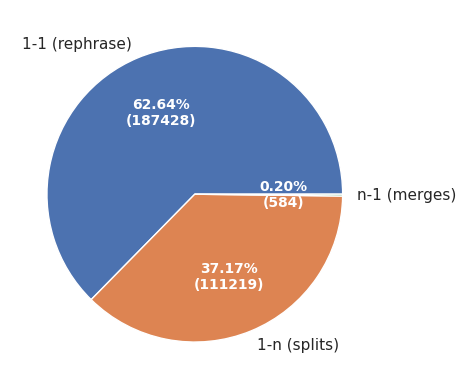

In [10]:
labels = ["1-1 (rephrase)", "1-n (splits)", "n-1 (merges)"]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct


fig, ax = plt.subplots()       
_, _, autotexts = ax.pie(list(alignments.values()), labels=labels, autopct=make_autopct(sizes))
plt.setp(autotexts, size=10, weight="bold", color="white")
plt.show()

# Sentece Length

In [11]:
sents_data = {"value": ["min", "max", "avg", "min", "max", "avg"], "sents_count": [], "origin": ["src", "src", "src", "tgt", "tgt", "tgt"]}
src_sents_len = []
tgt_sents_len = []

for index, row in df.iterrows():
    src_len = len(sent_tokenize(row["src"]))
    tgt_len = len(sent_tokenize(row["tgt"]))

    src_sents_len.append(src_len)
    tgt_sents_len.append(tgt_len)

sents_data["sents_count"].append(min(src_sents_len))
sents_data["sents_count"].append(max(src_sents_len))
sents_data["sents_count"].append(round(mean(src_sents_len), 2))

sents_data["sents_count"].append(min(tgt_sents_len))
sents_data["sents_count"].append(max(tgt_sents_len))
sents_data["sents_count"].append(round(mean(tgt_sents_len), 2))

df_sents = pd.DataFrame(data=sents_data)

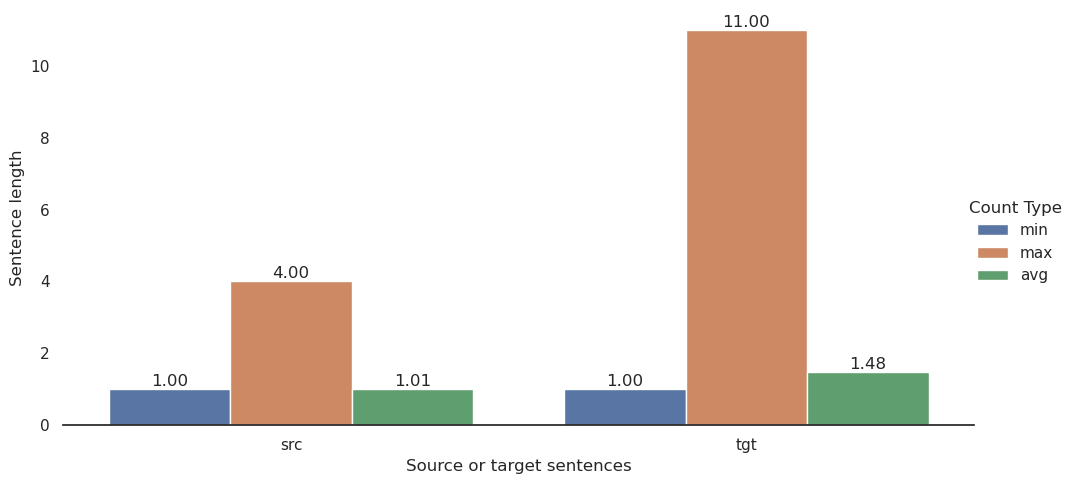

In [12]:
# Sentence length
g2 = sns.catplot(
    data=df_sents,
    kind="bar",
    x="origin",
    y="sents_count",
    hue="value",
    errorbar="sd",
    height=5,
    aspect=2,
)
g2.despine(left=True)
g2.set_axis_labels("Source or target sentences", "Sentence length")
g2.legend.set_title("Count Type")

ax = g2.facet_axis(0, 0)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, ha='center', va='bottom')

# Token length

In [13]:
token_data = {"value": ["min", "max", "avg", "min", "max", "avg"], "count": [], "origin": ["src", "src", "src", "tgt", "tgt", "tgt"]}
src_token_len = []
tgt_token_len = []

for index, row in df.iterrows():
    src_len = len(word_tokenize(row["src"]))
    tgt_len = len(word_tokenize(row["tgt"]))

    src_token_len.append(src_len)
    tgt_token_len.append(tgt_len)

token_data["count"].append(min(src_token_len))
token_data["count"].append(max(src_token_len))
token_data["count"].append(round(mean(src_token_len), 2))

token_data["count"].append(min(tgt_token_len))
token_data["count"].append(max(tgt_token_len))
token_data["count"].append(round(mean(tgt_token_len), 2))

df_tokens = pd.DataFrame(data=token_data)

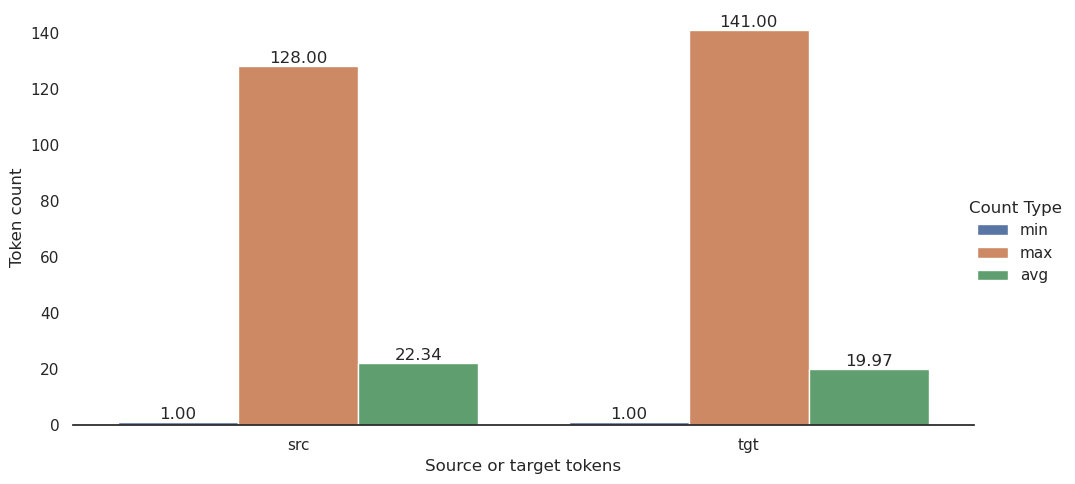

In [14]:
# Token length
g3 = sns.catplot(
    data=df_tokens,
    kind="bar",
    x="origin",
    y="count",
    hue="value",
    errorbar="sd",
    height=5,
    aspect=2,
)
g3.despine(left=True)
g3.set_axis_labels("Source or target tokens", "Token count")
g3.legend.set_title("Count Type")

ax2 = g3.facet_axis(0, 0)

for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, ha='center', va='bottom')

# Novelty

In [15]:
percentages = []

for index, row in df.iterrows():
    tgt_token = word_tokenize(row["tgt"])
    src_token = word_tokenize(row["src"])

    tgt_token = set([x.lower() for x in tgt_token])
    src_token = set([x.lower() for x in src_token])

    diff = tgt_token.difference(src_token)
    percentages.append(len(diff) / len(tgt_token))

novelty = round(mean(percentages) * 100, 2)

In [16]:
novelty

29.5

# FKGL

In [17]:
data_fkgl = {
    "origin": ["src", "tgt"],
    "fkgl": [corpus_fkgl(df["src"]), corpus_fkgl(df["tgt"])]
}
df_fkgl = pd.DataFrame(data=data_fkgl)

In [18]:
df_fkgl

,origin,fkgl
0,src,9.344041
1,tgt,4.790009


[Text(0, 0, '9.34'), Text(0, 0, '4.79')]

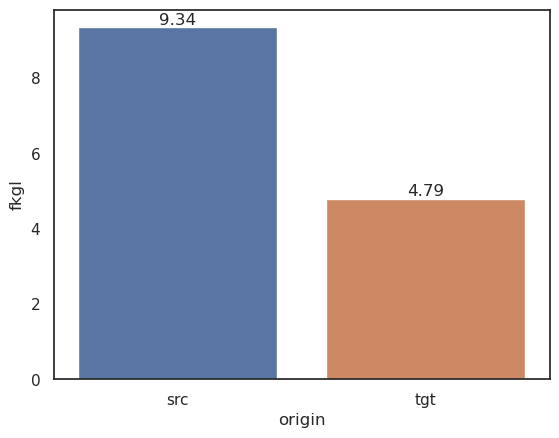

In [19]:
ax3 = sns.barplot(data=df_fkgl, x="origin", y="fkgl")
labels = [f'{round(df_fkgl.iloc[i, 1], 2)}' for i, v in enumerate(ax3.containers[0])]
ax3.bar_label(ax3.containers[0], labels=labels)